# Proyecto I: Filter Me!!

El objetivo de este proyecto es desarrollar una serie de filtros donde se utilice conceptos de mejora de contraste, y uso de mascaras de filtrado espacial para alterar una imagen obtenida a travez de una camara de video, en tiempo real. La imagen adquirida y procesada debe estar en escala de color. Para este proyecto se pide que los estudiantes implementen las funciones de:

1. Ecualización de histograma.
2. Difuminado de imagenes.
3. Detección de bordes.
4. Mejora de la Nitidez (sharpness).

El entregable debe cumplir las siguientes caracteristicas:

1. Facil de usar.
2. Se debe poder seleccionar que tipo de proceso se realiza sobre la imagen (ecualizacion de histograma, detecci'on bordes, etc)
3. Se debe mostrar la salida en tiempo real, es decir se debe mostrar el video actual como se procesa.
4. Tambien debe mostrar ejemplos de imagenes procesadas (Offline) con cada uno de los algoritmos implementados.

Al entregar el proyecto deben presentar los programas, ya sea en un ejecutable o en un notebook de jupiter. y deben entregar las respuestas a las psiguientes preguntas:

1. ¿Cual de los programas implementados corre de forma más lenta y cual de forma más rápida? ¿Porqué?
2. ¿Cómo puedo mejorar la velocidad de los algoritmos de procesamiento? ¿Qué consecuencias tiene esto?
3. Si los programas tienen problemas para realizar las operaciones dentro del tiempo considerado tiempo real, ¿cómo se puede mejorar esto?
4. ¿Fueron los resultados obtenidos satisfactorios? Elabore su respuesta.


Para realizar los programas pueden usar las librerias opencv, esta soporta el manejo de video. Por otro lado pueden usar [gradio](https://gradio.app) para desarrollar una interfaz de forma facil.

Para el desarrollo del proyecto se debne hacer en grupos de dos personas (solo se admite un grupo de 3). Tenga en cuenta que con quien desarrolla este proyecto, no puede desarrollar proyecto en un futuro. **La fecha limite de entrega del proyecto es el Lunes 28 de Febrero del 2022.**

Mucha suerte!!

In [1]:
import numpy as np
# import numba as nb 
import cv2
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
def convolve2D(image: np.ndarray, kernel: np.ndarray):
    return signal.convolve2d(image, kernel, mode='same', boundary='fill')

In [3]:
def make_sobelx_kernel():
    return np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])

In [4]:
def make_sobely_kernel():
    return np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])

In [35]:
def laplacian_kernel():
    return np.array([[0,1,0],[1,-4,1],[0,1,0]])

In [45]:
def sobel(img: np.ndarray):
    
    #convierte la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #hace el kernel sobel x
    kx = make_sobelx_kernel()

    #hace el kernel sobel y
    ky = make_sobely_kernel()
    
    #aplica el filtro sobel en x e y 
    convolved_img_x = convolve2D(gray, kx)
    convolved_img_y = convolve2D(gray, ky)

    #suma las imagenes filtradas con sobel
    convolved_img = (convolved_img_x + convolved_img_y)/2
    
    
    return convolved_img.astype('uint8')

In [46]:
def laplace(img):
    #convierte la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #kernel de laplace
    kl = laplacian_kernel()
    
    #aplica el filtro sobel en x e y 
    convolved_img = convolve2D(gray, kl)

    return convolved_img.astype('uint8')

Wall time: 121 ms


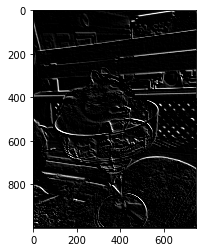

In [6]:
%%time
img = cv2.imread("../imgs/img1.jpg") 
plt.imshow(sobel(img), cmap='gray', vmin=0, vmax=255)

In [7]:
def difuminate(img, filter_size):
  filtered = np.zeros(img.shape)
  _,_, colordim = np.shape(img)
  x = np.full((filter_size,filter_size),1/(filter_size*filter_size))
  for dim in range(colordim):
    
    filtered[:,:,dim] = convolve2D(img[:,:,dim], x)
  return filtered.astype('uint8')

Wall time: 6.93 s


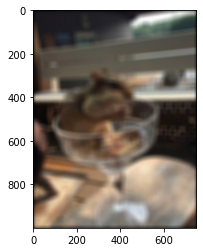

In [8]:
%%time
img = cv2.cvtColor(cv2.imread("../imgs/img1.jpg") , cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.imshow(difuminate(img,30))

In [9]:
def equalize_hsv_channel(img, channel=2):
  n, m, _ = np.shape(img)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  sat = img[:,:,channel]
  unique, counts = np.unique(sat, return_counts=True) 
  mapping = np.zeros(256)
  mapping[unique] = counts
  mapping = 255/(m*n)*np.cumsum(mapping)
  img[:,:,channel] = mapping[sat]
  return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)


In [10]:
# %%time
# img = cv2.cvtColor(cv2.imread("../imgs/img1.png") , cv2.COLOR_BGR2RGB)
# plt.imshow(np.column_stack([img,equalize_hsv_channel(img, 2)]))

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


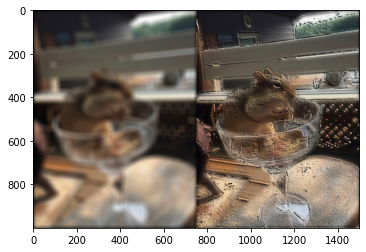

In [25]:
# Sharpness (substracting edges)
img = cv2.cvtColor(cv2.imread("../imgs/img1.jpg") , cv2.COLOR_BGR2RGB)
difuminate_original = difuminate(img,30)
# difuminate_original = img
difuminate_img = cv2.cvtColor(difuminate_original, cv2.COLOR_RGB2HSV)

sobel_output = sobel(img)
difuminate_img[:,:,2] = difuminate_img[:,:,2] - sobel_output
output = cv2.cvtColor(difuminate_img, cv2.COLOR_HSV2RGB)
plt.imshow(np.column_stack([difuminate_original, output]))

In [41]:
def sharpness_laplace(img):
    borders = laplace(img)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = img_hsv[:,:,2] - borders
    output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return output.astype('uint8')

Wall time: 959 ms


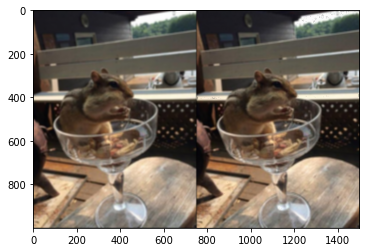

In [52]:
%%time
difuminate_original = difuminate(img,10)
plt.imshow(np.column_stack([difuminate_original, sharpness_laplace(difuminate_original)]))
# plt.imshow(laplace(img), cmap='gray', vmin=0, vmax=255)
# laplace(img).shape

In [55]:
def sharpness_mixed(img):
    borders_laplace = laplace(img)
    borders_sobel = sobel(img)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     img_hsv[:,:,2] = img_hsv[:,:,2] - ((borders_laplace + borders_sobel)/2)
    img_hsv[:,:,2] = img_hsv[:,:,2] - borders_laplace - borders_sobel
    output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return output.astype('uint8')

Wall time: 1.06 s


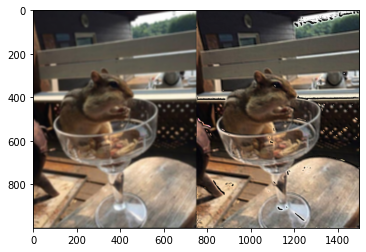

In [57]:
%%time
difuminate_original = difuminate(img,10)
plt.imshow(np.column_stack([difuminate_original, sharpness_mixed(difuminate_original)]))